In [1]:
import os
import sys
import argparse
import pickle
import random
from copy import deepcopy
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
# from qiskit_experiments.library import StandardRB, InterleavedRB

from qiskit import (
    QuantumCircuit, 
    QuantumRegister, 
    ClassicalRegister, 
    pulse) 
# This is where we access all of our Pulse features!
from qiskit.circuit import Parameter, Gate
from qiskit.circuit.library import XGate
from qiskit.pulse import Delay,Play
# This Pulse module helps us build sampled pulses for common pulse shapes
from qiskit.pulse import library as pulse_lib
# from qiskit.providers.ibmq.managed import IBMQJobManager
# from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# current_dir = os.getcwd()
# package_path = os.path.abspath(current_dir)
# sys.path.insert(0, package_path)

from utils.run_jobs import run_jobs
import common.pulse_types as pt


In [2]:
pulse_dict = {
    "gauss": [pt.Gaussian, pt.LiftedGaussian],
    "lor": [pt.Lorentzian, pt.LiftedLorentzian],
    "lor2": [pt.Lorentzian2, pt.LiftedLorentzian2],
    "lor3": [pt.Lorentzian3, pt.LiftedLorentzian3],
    "sq": [pt.Constant, pt.Constant],
    "sech": [pt.Sech, pt.LiftedSech],
    "sech2": [pt.Sech2, pt.LiftedSech2],
    "sin": [pt.Sine, pt.Sine],
    "sin2": [pt.Sine2, pt.Sine2],
    "sin3": [pt.Sine3, pt.Sine3],
    "sin4": [pt.Sine4, pt.Sine4],
    "sin5": [pt.Sine5, pt.Sine5],
    "demkov": [pt.Demkov, pt.LiftedDemkov],
}

In [3]:
COMP_PARAMS = {
    "X": {
        1: [{"alpha": 1, "phases": [1/2]}],
        3: [{"alpha": 1, "phases": [1/6, 5/6]}],
        5: [{"alpha": 1, "phases": [0.0672, 0.3854, 1.1364]}],
        7: [{"alpha": 1, "phases": [0.2560, 1.6839, 0.5933, 0.8306]},
           {"alpha": [0.26216650072338854, 0.31654687577570756, 0.31654687577570756, 0.31654687577570756, 0.31654687577570756, 0.31654687577570756, 0.23991346939666508], 
            "phases": [-0.2681786687850911, 0.262007101043305, 0.1158282957504724, 0.058347259736134145, -0.2714955767202196, -0.1544419019664696, 0.38186913558140173]}],
        9: [{"alpha": 1, "phases": [0.3951, 1.2211, 0.7806, 1.9335, 0.4580]}],
        11: [{"alpha": 1, "phases": [0.7016, 1.1218, 1.8453, 0.9018, 0.3117, 0.1699]}],
        13: [{"alpha": 1, "phases": [0.1200, 0.3952, 1.5643, 0.0183, 0.9219, 0.4975,1.1096]}],
        15: [{"alpha": 1, "phases": [0.5672, 1.4322, 0.9040, 0.2397, 0.9118, 0.5426, 1.6518, 0.1406]}],
        17: [{"alpha": 1, "phases": [0.3604, 1.1000, 0.7753, 1.6298, 1.2338, 0.2969, 0.6148, 1.9298, 0.4443]}]
    },
    "H": {
        3: [{"alpha": 0.6399, "phases": [1.8442, 1.0587]}],
        5: [{"alpha": 0.45, "phases": [1.9494, 0.5106, 1.3179]}],
        7: [{"alpha": 0.2769, "phases": [1.6803, 0.2724, 0.8255, 1.6624]}],
        9: [{"alpha": 0.2947, "phases": [1.2711, 0.1069, 0.5283, 1.1283, 1.9884]}],
        11: [{"alpha": 0.2985, "phases": [1.7377, 0.1651, 0.9147, 0.1510, 0.9331, 1.6415]}],
        13: [{"alpha": 0.5065, "phases": [0.0065, 1.7755, 0.7155, 0.5188, 0.2662, 1.2251, 1.3189]}],
        15: [{"alpha": 0.3132, "phases": [1.2316, 0.9204, 0.2043, 1.9199, 0.8910, 0.7381, 1.9612, 1.3649]}],
    }
}

In [4]:
def make_all_dirs(path):
    folders = path.split("/")
    for i in range(2, len(folders) + 1):
        folder = "/".join(folders[:i])
        if not os.path.isdir(folder):
            os.mkdir(folder)

def get_calib_params(
    backend, qubit,
    pulse_type, 
    sigma, duration,
    remove_bg
):
    file_dir = os.getcwd()
    # file_dir = os.path.split(file_dir)[0]
    calib_dir = os.path.join(file_dir, "calibrations", backend, str(qubit))
    params_file = os.path.join(calib_dir, "actual_params.csv")
    print(params_file)
    if os.path.isfile(params_file):
        param_df = pd.read_csv(params_file)
    df = param_df[param_df.apply(
            lambda row: row["pulse_type"] == pulse_type and \
                row["duration"] == duration and \
                row["sigma"] == sigma and \
                row["rb"] == remove_bg, axis=1)]
    # print(df)
    idx = 0 
    if df.shape[0] > 1:
        idx = input("More than one identical calibrations found! "
                    "Which do you want to use? ")
    elif df.shape[0] < 1:
        raise ValueError("No entry found!")
    ser = df.iloc[idx]
    l = ser.at["l"]
    p = ser.at["p"]
    x0 = ser.at["x0"]

    return l, p, x0

def initialize_backend(backend):
    backend_full_name = "ibm_" + backend 
        # if backend in ["perth", "lagos", "nairobi", "oslo"] \
        #     else "ibmq_" + backend
    GHz = 1.0e9 # Gigahertz
    MHz = 1.0e6 # Megahertz
    us = 1.0e-6 # Microseconds
    ns = 1.0e-9 # Nanoseconds
    qubit = 0
    mem_slot = 0

    drive_chan = pulse.DriveChannel(qubit)
    # meas_chan = pulse.MeasureChannel(qubit)
    # acq_chan = pulse.AcquireChannel(qubit)
    
    backend_name = backend
    # provider = IBMQ.load_account()
    backend = QiskitRuntimeService(channel="ibm_quantum").backend(backend_full_name)
    print(f"Using {backend_name} backend.")
    pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
    backend_defaults = backend.defaults()
    backend_config = backend.configuration()

    center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]# 4962284031.287086 Hz
    num_qubits = backend_config.n_qubits

    q_freq = [backend_defaults.qubit_freq_est[q] for q in range(num_qubits)]
    dt = backend_config.dt

    return backend, pm, drive_chan, num_qubits, q_freq

def fit_function(
    x_values, 
    y_values, 
    function, 
    init_params,
    bounds
):
    fitparams, conv = curve_fit(
        function, 
        x_values, 
        y_values, 
        init_params, 
        maxfev=100000, 
        bounds=bounds
    )
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

def linear_func(x, a, b):
    return a * x + b




In [5]:
# Function to generate a random rotation sequence
def random_rotation_sequence(qc, qubit, gate=None):
    # Set the random seed, which should be the same for both Interleaved RB runs
    
    # Define the set of Clifford gates for the RB
    gate_set = ["X", "Y", "Z", "H", "SX", "S", "ID"]
    # Initialize the gate if first run
    if gate is None:
        gate = random.choice(gate_set)
    
        if gate == "X":
            qc.x(qubit)
        elif gate == "Y":
            qc.y(qubit)
        elif gate == "Z":
            qc.z(qubit)
        elif gate == "H":
            qc.h(qubit)
        elif gate == "SX":
            qc.sx(qubit)
        elif gate == "S":
            qc.s(qubit)
        elif gate == "ID":
            qc.id(qubit)

    else:

        if gate == "X":
            qc.x(qubit)
        elif gate == "Y":
            qc.y(qubit)
        elif gate == "Z":
            qc.z(qubit)
        elif gate == "H":
            qc.h(qubit)
        elif gate == "SX":
            qc.sx(qubit)
            qc.x(qubit)
        elif gate == "S":
            qc.s(qubit)
            qc.z(qubit)
        elif gate == "ID":
            qc.id(qubit)

    # # Define the possible rotation orders
    # rotation_orders = [
    #     ['rx', 'ry', 'rz'], ['rx', 'rz', 'ry'],
    #     ['ry', 'rx', 'rz'], ['ry', 'rz', 'rx'],
    #     ['rz', 'rx', 'ry'], ['rz', 'ry', 'rx']
    # ]

    # # Randomly select a rotation order and random angles of rotation
    # if order is None:
    #     order = random.choice(rotation_orders) 
    # if angles is None:
    #     angles = [random.uniform(0, 2 * np.pi) for _ in range(3)]

    # # Apply random rotations with random angles
    # for idx, rot in enumerate(order):

    #     if rot == 'rx':
    #         qc.rx(angles[idx], qubit)
    #     elif rot == 'ry':
    #         qc.ry(angles[idx], qubit)
    #     elif rot == 'rz':
    #         qc.rz(angles[idx], qubit)
            
    return gate

            
# Function to create RB circuits with random rotations, optionally interleaving a target gate
def generate_rb_circuits(lengths, num_sequences, qubit, drive_chan, random_seed, natural_freq, N, closest_amp, composite_gate=False, sched=False):
    
    rb_circuits = []
    
    delays = [0] if delay_int is None else np.arange(delay_min, delay_max, delay_int)
    frequencies = [natural_freq] if det_int is None else np.arange(natural_freq + det_min, natural_freq + det_max, det_int)
    intensities = [1] if amp_int is None else np.arange(amp_min, amp_max, amp_int)
    
    amplitude_values = np.ones((N))
    alpha = COMP_PARAMS[N][variant]["alpha"] if gate_name is None else COMP_PARAMS[gate_name][N][variant]["alpha"]
    phases = COMP_PARAMS[N][variant]["phases"] if gate_name is None else COMP_PARAMS[gate_name][N][variant]["phases"]
    
    if isinstance(alpha, list):
        amplitude_values = np.array(alpha)
    elif isinstance(alpha, float):
        amplitude_values[0] = alpha
        amplitude_values[-1] = alpha
    
    amplitude_values *= closest_amp
    phase_values = np.empty((N))
    
    if len(phases) == N:
        phase_values = np.array(phases)
    else:
        phase_values[:int(N/2) + 1] = np.array(phases)
        phase_values[int(N/2) + 1:] = np.array(phases)[::-1][1:]

    rabi_intensity = 1
    delay = 0

    def _generate_sched():
        with pulse.build(backend=backend, default_alignment='sequential', name="composite_gate") as sched:
            dur_dt = duration
            pulse.set_frequency(natural_freq, drive_chan)
            for idx, (amp, phi) in enumerate(zip(amplitude_values, phase_values)):
                if pulse_type == "sq" or pulse_type.startswith("sin"):
                    pulse_played = pulse_dict[pulse_type][remove_bg](
                        duration=dur_dt,
                        amp=rabi_intensity * amp * np.exp(1j * phi * np.pi),
                        name=pulse_type
                    )
                elif pulse_type == "gauss":
                    pulse_played = pulse_dict[pulse_type][remove_bg](
                        duration=dur_dt,
                        amp=rabi_intensity * amp * np.exp(1j * phi * np.pi),
                        name=pulse_type,
                        sigma=sigma / np.sqrt(2)
                    )
                elif pulse_type in ["lor", "lor2", "lor3"]:
                    pulse_played = pulse_dict[pulse_type][remove_bg](
                        duration=dur_dt,
                        amp=rabi_intensity * amp * np.exp(1j * phi * np.pi),
                        name=pulse_type,
                        sigma=sigma,
                    )
                else:
                    pulse_played = pulse_dict[pulse_type][remove_bg](
                        duration=dur_dt,
                        amp=rabi_intensity * amp * np.exp(1j * phi * np.pi),
                        name=pulse_type,
                        sigma=sigma,
                    )
                pulse.play(pulse_played, drive_chan)
                # if idx < len(amplitude_values) - 1:
                #     pulse.delay(delay, drive_chan)
        return sched
    random.seed(random_seed)

    for length in lengths:
        for _ in range(num_sequences):
            # Create a new circuit for each sequence
            qc = QuantumCircuit(qubit + 1, 1)
            
            gates = []
            scheds = [None] * length
            for idx in range(length):
                # Apply a random rotation sequence to the qubit
                gate = random_rotation_sequence(qc, qubit)
                
                # Interleave the target gate if provided
                if composite_gate is None:
                    pass
                elif composite_gate == True:
                    comp_gate = Gate("comp_gate", 1, [])
                    qc.append(comp_gate, [qubit])
                else:
                    qc.x(qubit)

                    
                    
                if sched:
                    scheds[idx] = _generate_sched()
                    scheds[idx].draw()
                    qc.add_calibration(comp_gate, (qubit,), scheds[idx], [])

                gates.append(gate)

            # Apply the inverse rotation (for simplicity, we apply the same rotations again but reversed)
            inverse_scheds = [None] * length
            for idx in range(length):
                # Inverse interleave the target gate if provided
                if composite_gate is None:
                    pass
                elif composite_gate == True:
                    comp_gate = Gate("comp_gate", 1, [])
                    qc.append(comp_gate, [qubit])
                else:
                    qc.x(qubit)
                    
                if sched:
                    inverse_scheds[idx] = _generate_sched()
                    qc.add_calibration(comp_gate, (qubit,), inverse_scheds[idx], [])
                idx_reverse = length - 1 - idx
                random_rotation_sequence(qc, qubit, gates[idx_reverse][::-1])
            
            # Add measurement
            qc.measure(qubit, 0)

            rb_circuits.append(qc)
    
    return rb_circuits


# Function to fit the fidelity decay curve
def fit_fidelity_decay(lengths, fidelities):
    def decay_func(x, a, b, p):
        return a + p**x

    popt, _ = curve_fit(decay_func, lengths, fidelities, maxfev=10000, bounds=((0,0,0), (1,1,1)))
    return popt


In [6]:
def run_interleavedRB(
    duration, sigma, 
    pulse_type, remove_bg, N=5, variant=0, gate_name=None,
    max_exp_per_job=50,
    num_shots=1024, backend="manila",
    l=100, p=0.5, x0=0,
    qubit=0, random_seed=42,
    closest_amp=None,
    lengths=[1, 2, 4, 8, 16], num_sequences=10
):
    backend, pm, drive_chan, num_qubits, q_freq = initialize_backend(backend)
    if closest_amp is None:
        closest_amp = -np.log(1 - np.pi / l) / p + x0
    # amplitudes = np.linspace(
    #     closest_amp - amp_span / 2,
    #     closest_amp + amp_span / 2,
    #     num_exp
    # )
    # Ns = np.arange(0, N_max + N_interval / 2, N_interval, dtype="int64")
    natural_freq = q_freq[qubit]
    delays = [0] if delay_int is None else np.arange(delay_min, delay_max, delay_int)
    frequencies = [natural_freq] if det_int is None else np.arange(natural_freq + det_min, natural_freq + det_max, det_int)
    intensities = [1] if amp_int is None else np.arange(amp_min, amp_max, amp_int)
    
    amplitude_values = np.ones((N))
    alpha = COMP_PARAMS[N][variant]["alpha"] if gate_name is None else COMP_PARAMS[gate_name][N][variant]["alpha"]
    phases = COMP_PARAMS[N][variant]["phases"] if gate_name is None else COMP_PARAMS[gate_name][N][variant]["phases"]
    if isinstance(alpha, list):
        amplitude_values = np.array(alpha)
    elif isinstance(alpha, float):
        amplitude_values[0] = alpha
        amplitude_values[-1] = alpha
    amplitude_values *= closest_amp
    
    phase_values = np.empty((N))
    if len(phases) == N:
        phase_values = np.array(phases)
    else:
        phase_values[:int(N/2) + 1] = np.array(phases)
        phase_values[int(N/2) + 1:] = np.array(phases)[::-1][1:]

    rabi_intensity = 1
    delay = 0
    # freq = Parameter("freq")
    # rabi_intensity = Parameter("rabi_intensity")
    # delay = Parameter("delay")
    
    # Generate standard RB circuits (without interleaved gate)
    rb_circuits = generate_rb_circuits(lengths, num_sequences, qubit, drive_chan, random_seed, natural_freq, N, closest_amp, None, False)
    rb_circuits_pm = pm.run(rb_circuits)
    
    # Generate interleaved RB circuits (with the target gate interleaved)
    irb_circuits_comp = generate_rb_circuits(lengths, num_sequences, qubit, drive_chan, random_seed, natural_freq, N, closest_amp, True, True)
    irb_circuits_pm_comp = pm.run(irb_circuits_comp)
    
    # Generate interleaved RB circuits (with the target gate interleaved)
    irb_circuits_drag = generate_rb_circuits(lengths, num_sequences, qubit, drive_chan, random_seed, natural_freq, N, closest_amp, False, False)
    irb_circuits_pm_drag = pm.run(irb_circuits_drag)

    result_rb, job_ids_rb = run_jobs(rb_circuits_pm, backend, duration * len(lengths) * num_sequences, num_shots_per_exp=num_shots)
    result_irb_comp, job_ids_irb_comp = run_jobs(irb_circuits_pm_comp, backend, duration * len(lengths) * num_sequences, num_shots_per_exp=num_shots)
    result_irb_drag, job_ids_irb_drag = run_jobs(irb_circuits_pm_drag, backend, duration * len(lengths) * num_sequences, num_shots_per_exp=num_shots)
    
    # Analyze the results for standard RB
    fidelities_rb = []
    for i, length in enumerate(lengths):
        correct_counts = 0
        total_counts = 0
        for seq in range(num_sequences):
            measured = result_rb[i * num_sequences + seq] # results_rb.get_counts(i * num_sequences + seq)
            correct_counts += measured * num_shots 
            total_counts += num_shots
        fidelity = 1 - correct_counts / total_counts
        fidelities_rb.append(fidelity)
    
    # Analyze the results for interleaved RB
    fidelities_irb_comp = []
    for i, length in enumerate(lengths):
        correct_counts = 0
        total_counts = 0
        for seq in range(num_sequences):
            measured = result_irb_comp[i * num_sequences + seq] # results_rb.get_counts(i * num_sequences + seq)
            correct_counts += measured * num_shots 
            total_counts += num_shots
        fidelity = 1 - correct_counts / total_counts
        fidelities_irb_comp.append(fidelity)
        
    # Analyze the results for interleaved RB
    fidelities_irb_drag = []
    for i, length in enumerate(lengths):
        correct_counts = 0
        total_counts = 0
        for seq in range(num_sequences):
            measured = result_irb_drag[i * num_sequences + seq] # results_rb.get_counts(i * num_sequences + seq)
            correct_counts += measured * num_shots 
            total_counts += num_shots
        fidelity = 1 - correct_counts / total_counts
        fidelities_irb_drag.append(fidelity)
    return lengths, fidelities_rb, fidelities_irb_comp, fidelities_irb_drag


def fit_fidelities(lengths, fidelities_rb, fidelities_irb_comp, fidelities_irb_drag):
    # Fit the fidelity decay curves
    a_rb, b_rb, p_rb = fit_fidelity_decay(lengths, fidelities_rb)
    a_irb_comp, b_irb_comp, p_irb_comp = fit_fidelity_decay(2*np.array(lengths), fidelities_irb_comp)
    a_irb_drag, b_irb_drag, p_irb_drag = fit_fidelity_decay(2*np.array(lengths), fidelities_irb_drag)
    
    # Calculate the error per gate for the interleaved gate
    d = 2
    
    epc_comp = (d - 1) / d * (1 - p_irb_comp / p_rb)
    
    epc_drag = (d - 1) / d * (1 - p_irb_drag / p_rb)
    
    # Plot the results
    plt.figure()
    plt.plot(lengths, fidelities_rb, 'o', label='Standard RB')
    plt.plot(lengths, a_rb + np.array(p_rb) ** np.array(lengths), label=f'Fit Standard (p={p_rb:.4f})')
    plt.plot(lengths, fidelities_irb_comp, 'o', label='Composite Interleaved RB')
    plt.plot(lengths, a_irb_comp + np.array(p_irb_comp) ** (2 * np.array(lengths)), label=f'Fit Comp. Interleaved (p={p_irb_comp:.4f})')
    plt.plot(lengths, fidelities_irb_drag, 'o', label='DRAG Interleaved RB')
    plt.plot(lengths, a_irb_drag + np.array(p_irb_drag) ** (2 * np.array(lengths)), label=f'Fit DRAG Interleaved (p={p_irb_drag:.4f})')
    plt.xlabel('Sequence Length')
    plt.ylabel('Fidelity')
    plt.legend()
    plt.show()
    
    print(f'Estimated error per gate for composite gate: {epc_comp}')
    print(f'Estimated error per gate for DRAG gate: {epc_drag}')
    return epc_comp, epc_drag 


def find_least_variation(x, ys, init_params=[1, 1], bounds=[[-100, -100],[100, 100]]):
    # y_fits = []
    # for y in ys:
    #     par, y_fit = fit_function(x, y, linear_func, init_params, bounds)
    #     y_fits.append(y_fit)
    # y_fits = np.array(y_fits)
    # diff = np.mean(np.abs(ys - y_fits[:, None]), axis=1)
    diff = np.sum(ys, 1)
    closest_idx = np.argmin(diff)
    return closest_idx


In [7]:
pulse_type, qubit, closest_amp, sigma, duration, N, variant, gate_name = "sq", 46, None, 64, 64, 5, 0, "X"
delay_int, delay_min, delay_max, amp_int, amp_min, amp_max = None, 32, 1000, None, 0, 2
det_int, det_min, det_max, remove_bg, max_experiments_per_job = None, -1e6, 1e6, 0, 100
num_shots, num_exp, backend, amp_span, num_iterations = 256, 100, "sherbrooke", 0.01, 3
random_seed, lengths, num_sequences = 142, np.arange(18), 10

C:\Users\Ivo\Documents\qiskit_experiments\calibrations\sherbrooke\46\actual_params.csv


C:\Users\Ivo\AppData\Local\Temp\ipykernel_36900\3050059174.py:51: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  drive_chan = pulse.DriveChannel(qubit)


Using sherbrooke backend.


C:\Users\Ivo\AppData\Local\Temp\ipykernel_36900\1886402286.py:103: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(backend=backend, default_alignment='sequential', name="composite_gate") as sched:
C:\Users\Ivo\AppData\Local\Temp\ipykernel_36900\1886402286.py:105: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(natural_freq, drive_chan)
C:\Users\Ivo\AppData\Local\Temp\ipykernel_36900\1886402286.py:134: DeprecationWarning: The function ``qiskit.pulse.builder.play()``

Num experiments, size = 180 530841600
I am in SECOND loop. Max size of part is 86
QUEUED
QUEUED
QUEUED
Num experiments, size = 180 530841600
I am in SECOND loop. Max size of part is 86
QUEUED
QUEUED
QUEUED
Num experiments, size = 180 530841600
I am in SECOND loop. Max size of part is 86
QUEUED
QUEUED
QUEUED


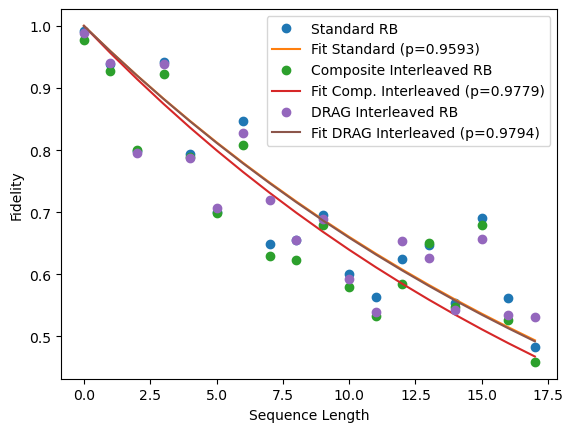

Estimated error per gate for composite gate: -0.009668321155560489
Estimated error per gate for DRAG gate: -0.01043085341305583
Save to pickle successful!


NameError: name 'frequencies' is not defined

In [8]:
dt_now = datetime.now()

l, p, x0 = get_calib_params(
    backend, qubit, pulse_type, 
    sigma, duration,
    remove_bg
)
# for i in range(num_iterations):
lengths, fidelities_rb, fidelities_irb_comp, fidelities_irb_drag = run_interleavedRB(
    # amp_span / (10**i), 
    duration, sigma, 
    pulse_type, remove_bg,
    N=N, variant=variant, gate_name=gate_name,
    # delay_int=delay_int, delay_min=delay_min, 
    # delay_max=delay_max,
    # amp_int=amp_int, amp_min=amp_min, 
    # amp_max=amp_max, det_int=det_int, 
    # det_min=det_min, det_max=det_max,
    max_exp_per_job=max_experiments_per_job,
    num_shots=num_shots, 
    backend=backend,
    l=l, p=p, x0=x0,
    qubit=qubit, random_seed=random_seed,
    closest_amp=None,
    lengths=lengths, num_sequences=num_sequences)
    # index = find_least_variation(intensities, values)
    # closest_amp = intensities[index]

epc_comp, epc_drag = fit_fidelities(lengths, fidelities_rb, fidelities_irb_comp, fidelities_irb_drag)

file_dir = os.getcwd()
file_dir = os.path.split(file_dir)[0]
time = dt_now.strftime("%H%M%S")
date = dt_now.strftime("%Y-%m-%d")
plot_save_dir = os.path.join(file_dir, "plots", backend, str(qubit), "composites", date)
data_save_dir = os.path.join(file_dir, "data", backend, str(qubit), "composites", date)
make_all_dirs(plot_save_dir.replace("\\","/"))
make_all_dirs(data_save_dir.replace("\\","/"))
with open(os.path.join(data_save_dir, f"{time}_comp_gates_{duration}dt_{N}pulses_v{variant}.pkl").replace("\\","/"), 'wb') as f:
    pickle.dump((epc_comp, epc_drag, lengths, fidelities_rb, fidelities_irb_comp, fidelities_irb_drag), f)
print("Save to pickle successful!")

params = np.array([(q, i, d) for q in frequencies for i in intensities for d in delays])
# print(params)
is_variable = [None] * 3
for i in range(len(params[0])):
    is_variable[i] = False if (params[:, i] == np.roll(params[:, i], 1)).all() else True

variable_dict = {
    0: "Detuning [MHz]",
    1: "Amplitude [arb. units]",
    2: "Delays [dt]"
}
num_variables = np.sum(is_variable)
if num_variables == 1:
    variable_type = np.where(is_variable)[0][0]
    variable = params[:, variable_type]
elif num_variables == 2:
    variable_type = [np.where(is_variable)[0][0], np.where(is_variable)[0][1]]
    variable = [params[:, variable_type[0]], params[:, variable_type[1]]]
else:
    print("Too few/many variables, choose 1 or 2 manually.")

if num_variables == 1:
    fig, ax = plt.subplots()
    sc = ax.scatter(variable, values)
    ax.set_xlabel(variable_dict[variable_type])
    ax.set_ylabel("Transition probability")
    plt.show()
    plt.savefig(os.path.join(plot_save_dir, f"{time}_composites_{variable_dict[variable_type]}_{duration}dt_{N}pulses_v{variant}.png").replace("\\","/"))

if num_variables == 2:
    fig, ax = plt.subplots(1, 1)
    c = ax.pcolormesh(variable[0], variable[1], values.reshape(len(variable[0]), len(variable[1])))
    ax.set_xlabel(variable_dict[variable_type[0]])
    ax.set_ylabel(variable_dict[variable_type[1]])
    fig.colorbar(c, ax=ax)
    plt.show()
    plt.savefig(os.path.join(plot_save_dir, f"{time}_composites_{variable_dict[variable_type[0]]},{variable_dict[variable_type[1]]}_{duration}dt_{N}pulses_v{variant}.png").replace("\\","/"))
print("Figure saved successfully!")

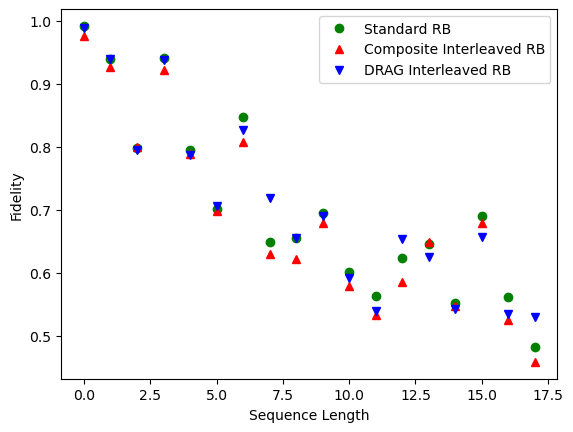

In [9]:
plt.figure()
plt.plot(lengths, fidelities_rb, 'go', label='Standard RB')
# plt.plot(lengths, a_rb + b_rb * np.array(p_rb) ** np.array(lengths), label=f'Fit Standard (p={p_rb:.4f})')
plt.plot(lengths, fidelities_irb_comp, 'r^', label='Composite Interleaved RB')
# plt.plot(lengths, a_irb_comp + b_irb_comp * np.array(p_irb_comp) ** np.array(lengths), label=f'Fit Comp. Interleaved (p={p_irb_comp:.4f})')
plt.plot(lengths, fidelities_irb_drag, 'bv', label='DRAG Interleaved RB')
# plt.plot(lengths, a_irb_drag + b_irb_drag * np.array(p_irb_drag) ** np.array(lengths), label=f'Fit DRAG Interleaved (p={p_irb_drag:.4f})')
plt.xlabel('Sequence Length')
plt.ylabel('Fidelity')
plt.legend()
plt.show()

In [ ]:
epc_comp, epc_drag = fit_fidelities(lengths[:-4], np.array(fidelities_rb)[:-4], np.array(fidelities_irb_comp)[:-4], np.array(fidelities_irb_drag)[:-4])


In [ ]:
0.5*(1-0.9988/0.9995)

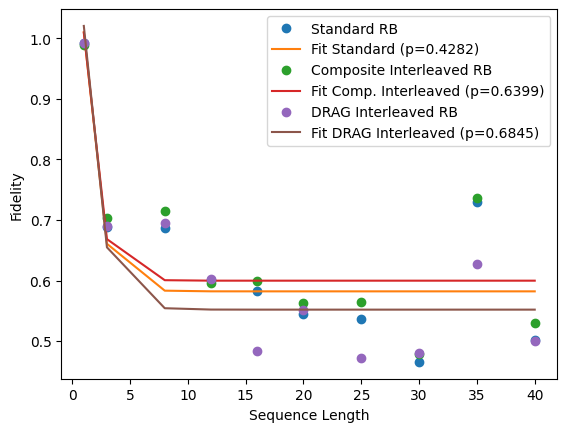

Estimated error per gate for composite gate: -0.24710756715813664
Estimated error per gate for DRAG gate: -0.29923968590194894
Save to pickle successful!


NameError: name 'frequencies' is not defined

In [13]:
epc_comp, epc_drag = fit_fidelities(lengths, fidelities_rb, fidelities_irb_comp, fidelities_irb_drag)

file_dir = os.getcwd()
file_dir = os.path.split(file_dir)[0]
time = dt_now.strftime("%H%M%S")
date = dt_now.strftime("%Y-%m-%d")
plot_save_dir = os.path.join(file_dir, "plots", backend, str(qubit), "composites", date)
data_save_dir = os.path.join(file_dir, "data", backend, str(qubit), "composites", date)
make_all_dirs(plot_save_dir.replace("\\","/"))
make_all_dirs(data_save_dir.replace("\\","/"))
with open(os.path.join(data_save_dir, f"{time}_comp_gates_{duration}dt_{N}pulses_v{variant}.pkl").replace("\\","/"), 'wb') as f:
    pickle.dump((epc_comp, epc_drag, lengths, fidelities_rb, fidelities_irb_comp, fidelities_irb_drag), f)
print("Save to pickle successful!")

params = np.array([(q, i, d) for q in frequencies for i in intensities for d in delays])
# print(params)
is_variable = [None] * 3
for i in range(len(params[0])):
    is_variable[i] = False if (params[:, i] == np.roll(params[:, i], 1)).all() else True

variable_dict = {
    0: "Detuning [MHz]",
    1: "Amplitude [arb. units]",
    2: "Delays [dt]"
}
num_variables = np.sum(is_variable)
if num_variables == 1:
    variable_type = np.where(is_variable)[0][0]
    variable = params[:, variable_type]
elif num_variables == 2:
    variable_type = [np.where(is_variable)[0][0], np.where(is_variable)[0][1]]
    variable = [params[:, variable_type[0]], params[:, variable_type[1]]]
else:
    print("Too few/many variables, choose 1 or 2 manually.")

if num_variables == 1:
    fig, ax = plt.subplots()
    sc = ax.scatter(variable, values)
    ax.set_xlabel(variable_dict[variable_type])
    ax.set_ylabel("Transition probability")
    plt.show()
    plt.savefig(os.path.join(plot_save_dir, f"{time}_composites_{variable_dict[variable_type]}_{duration}dt_{N}pulses_v{variant}.png").replace("\\","/"))

if num_variables == 2:
    fig, ax = plt.subplots(1, 1)
    c = ax.pcolormesh(variable[0], variable[1], values.reshape(len(variable[0]), len(variable[1])))
    ax.set_xlabel(variable_dict[variable_type[0]])
    ax.set_ylabel(variable_dict[variable_type[1]])
    fig.colorbar(c, ax=ax)
    plt.show()
    plt.savefig(os.path.join(plot_save_dir, f"{time}_composites_{variable_dict[variable_type[0]]},{variable_dict[variable_type[1]]}_{duration}dt_{N}pulses_v{variant}.png").replace("\\","/"))
print("Figure saved successfully!")

In [5]:
import os
import pickle
file_dir = os.getcwd()
file_dir = os.path.split(file_dir)[0]
data_save_dir = os.path.join(file_dir, "data", "sherbrooke", "46", "composites", "2024-10-06")
with open(os.path.join(data_save_dir, "153457_comp_gates_64dt_5pulses_v0.pkl"), 'rb') as f:
    epc_comp, epc_drag, lengths, fidelities_rb, fidelities_irb_comp, fidelities_irb_drag = pickle.load(f)


NameError: name 'a_rb' is not defined

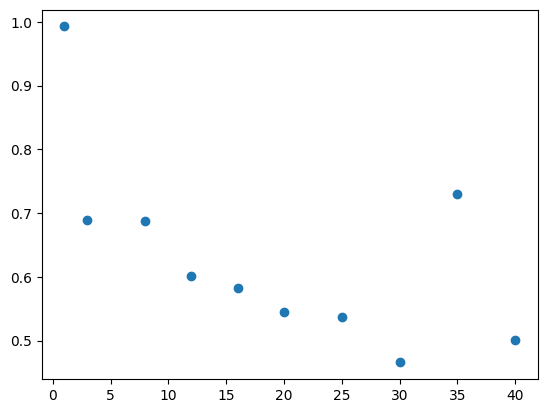

In [14]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(lengths, fidelities_rb, 'o', label='Standard RB')
plt.plot(lengths, a_rb + b_rb * np.array(p_rb) ** np.array(lengths), label=f'Fit Standard (p={p_rb:.4f})')
plt.plot(lengths, fidelities_irb_comp, 'r^', label='Composite Interleaved RB')
# plt.plot(lengths, a_irb_comp + b_irb_comp * np.array(p_irb_comp) ** np.array(lengths), label=f'Fit Comp. Interleaved (p={p_irb_comp:.4f})')
plt.plot(lengths, fidelities_irb_drag, 'bv', label='DRAG Interleaved RB')
# plt.plot(lengths, a_irb_drag + b_irb_drag * np.array(p_irb_drag) ** np.array(lengths), label=f'Fit DRAG Interleaved (p={p_irb_drag:.4f})')
plt.xlabel('Sequence Length')
plt.ylabel('Fidelity')
plt.grid(which='minor', linestyle='--', linewidth=0.5, alpha=0.5)  # Adding minor grid
plt.grid(which='major', linestyle='-', linewidth=0.8, alpha=1)  # Adding minor grid
plt.minorticks_on()  # Enabling minor ticks
plt.legend()
plt.show()